In [1]:
import tensorflow as tf
import numpy as np
import skimage
import os
import matplotlib.pyplot as plt

import warnings;
warnings.simplefilter('ignore')

GLOBAL_MEAN = np.array([144.75479165, 137.70713403, 129.666091])
GLOBAL_STD = np.array([62.56100901, 61.6901946 , 62.33278675])


def convert_to_tflite(input_file, output_file=None):
    if output_file is None:
        filepath, file_extension = os.path.splitext(input_file)
        output_file = "{}.tflite".format(filepath)
    converter = tf.lite.TFLiteConverter.from_keras_model_file(input_file)
    tflite_model = converter.convert()
    open(output_file, "wb").write(tflite_model)


def inference_tflite(image, interpreter, mean, std):
    h, w = image.shape[0], image.shape[1]
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape']
    image_resize = 255 * skimage.transform.resize(image, output_shape=input_shape[1:], order=1)
    input_data = np.expand_dims((image_resize-mean)/std, axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_mask = skimage.transform.resize(output_data[0], output_shape=(h, w), order=0)[...,0]
    return output_mask


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 190 variables.
INFO:tensorflow:Converted 190 variables to const ops.


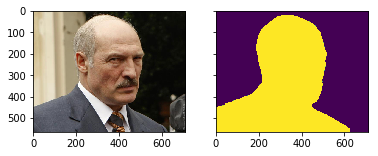

In [2]:
## convert keras model to tflite
FULL_GRAPH_PATH = os.path.join('./converted_models/', 'checkpoint_weights_512.0066--1.21_full_graph.h5')
OUTPUT_PATH = os.path.join("./converted_models/", "checkpoint_weights_512.0066--1.21.tflite")
convert_to_tflite(FULL_GRAPH_PATH, OUTPUT_PATH)

## Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=OUTPUT_PATH)
interpreter.allocate_tensors()

## predict a single image
image = skimage.io.imread("alpha_merged1.png")[...,:3]
res = inference_tflite(image, interpreter, mean=GLOBAL_MEAN, std=GLOBAL_STD)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image)
ax2.imshow(res)
plt.show()
plt.show()